### 1. Loading and Processing Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# ignore harmless warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import data from xlsx file
dataset = pd.read_excel('E:\\bca major project\\india data Excel.xlsx')
dataset.tail()

,Year,Inflation
58,2018-01-01,3.938826
59,2019-01-01,3.729506
60,2020-01-01,6.623437
61,2021-01-01,5.131407
62,2022-01-01,6.699034


In [3]:
dataset.columns=["Year","Rate"]
dataset.head()

,Year,Rate
0,1960-01-01,1.779878
1,1961-01-01,1.695213
2,1962-01-01,3.632215
3,1963-01-01,2.946161
4,1964-01-01,13.355261


In [4]:
# set date column as index
dataset.set_index('Year', inplace=True)
dataset.head()

,Rate
Year,
1960-01-01,1.779878
1961-01-01,1.695213
1962-01-01,3.632215
1963-01-01,2.946161
1964-01-01,13.355261


In [5]:
# summary of final DataFrame
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rate,63.0,7.365134,4.869688,-7.633948,4.12789,6.665657,9.748438,28.598734


### 2. Visualizing Time Series

Our dataset is ready for further actions. Lets plot some figures.

<AxesSubplot:xlabel='Year'>

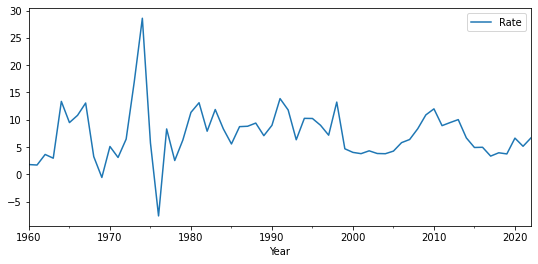

In [6]:
# time series of inflation percentage
dataset.plot(figsize=(9,4))

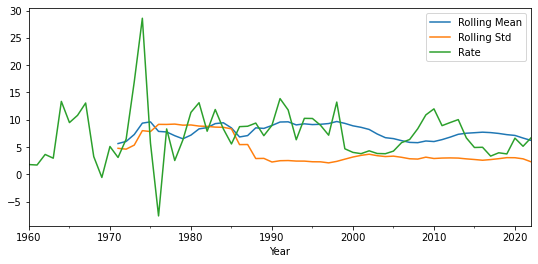

In [7]:
# more time series of inflation percentage
time_series = dataset['Rate']
time_series.rolling(window=12).mean().plot(label='Rolling Mean')
time_series.rolling(window=12).std().plot(label='Rolling Std')
time_series.plot(figsize=(9,4))
plt.legend()
plt.show()

From this plot we can see Polish inflation is a complex measure. The standard deviation is not flattened and the behaviour seems to be quite dynamic in time.

To understand more about our time series and get more insights for future predicting, we will plot it's decomposition. These components are defined as follows:
* observed: the actual value in the series;
* trend: the increasing or decreasing value in the series;
* seasonality: the repeating short-term cycle or pattern in the series;
* residual/noise: the random variation in the series.

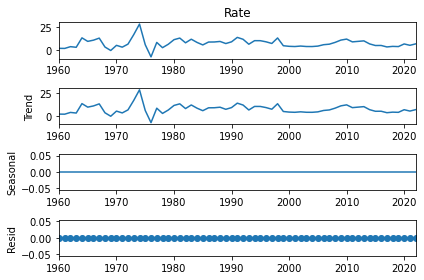

In [8]:
# plot decomposition components
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(time_series)
fig = decomp.plot()

### 3. Introduction to ARIMA Model

ARIMA (aka Box-Jenkins) is an acronym that is short for Auto Regressive Integrated Moving Average. It is a class of model that that captures a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.

Any non-seasonal time series that exhibits patterns and is not a random white noise can be modeled with ARIMA models. Seasonal changes or patterns require extending this model into Seasonal ARIMA (SARIMA) by adding seasonal terms. Since inflation in Poland is definitely non-seasonal, this type of model should fit great.

To build an accurate statistical model it is crucial to know its parameters <code>(p, d, q)</code> which are integer values.

The parameters of the ARIMA model are defined as follows:<br>
* <code>p</code>: number of lag observations included in the model, also called the lag order (AR term);
* <code>d</code>: number of times that the raw observations are differenced, also called the degree of differencing (I term);
* <code>q</code>: number of differencing required to make the time series stationary (MA term).

We need to find the value of each term, but before that we must check if our dataset is stationary.

### 4. Identifying if the Data is Stationary

To check if the inflation series is stationary, we will implement the Augmented Dickey Fuller (ADF) test. To identify the nature of data, we will be using the null hypothesis.

The null hypothesis ($H_0$) of the ADF test is that the data is non stationary. If the <code>P-value</code> of the test is less than the significance level (0.05) then we can reject the null hypothesis and infer that the series is indeed stationary.

So, in other words, if <code>P-value</code> is greater the 0.05 (data is non stationary) we will need to find the order of differencing. Otherwise, we can assign it is equal 0.

In [9]:
# check if inflation series is stationary
from statsmodels.tsa.stattools import adfuller

# ADF test
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print('1. ADF: ', result[0])
    print('2. P-value: ', result[1])
    print('3. Num of Lags: ', result[2])
    print('4. Num of Observations: ', result[3])
    print('5. Critial Values:')
    for key, value in result[4].items():
        print('\t', key, ': ', value)
        
    if result[1] <= 0.05:
        print('\nStrong evidence against the null hypothesis (H0), reject the null hypothesis. Data has no unit root and is stationary.')
    else:
        print('\nWeak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.')

# run function
adf_test(dataset['Rate'])

1. ADF:  -5.32631403358183
2. P-value:  4.82866878925221e-06
3. Num of Lags:  3
4. Num of Observations:  59
5. Critial Values:
	 1% :  -3.5463945337644063
	 5% :  -2.911939409384601
	 10% :  -2.5936515282964665

Strong evidence against the null hypothesis (H0), reject the null hypothesis. Data has no unit root and is stationary.


### 5. Differencing - Determining *d* Order

Using <code>pmdarima</code> package we can easily find value of <code>d</code> term with different tests. Since our time series is stationary, we will still accept <code>d</code> term to be 0 because there is no need of calculating it.

In our case data is Stationary. Hance no need to Differentiate.

### 6. Autocorrelation (ACF) and Partial Autocorrelation (PACF) - Determining *p* and *q* Order

Autocorrelation it is a statistic describing the extent to which a given term of the series depends on the previous terms in the time series (with a constant time shift). Partial autocorrelation expresses the correlation between observations made at two points in time while accounting for any influence from other observations.

By plotting ACF and PACF we are able to determine <code>p</code> and <code>q</code>. We can use ACF to determine the optimal number of MA terms and PACF to determine the optimal number of terms to use in the AR model.

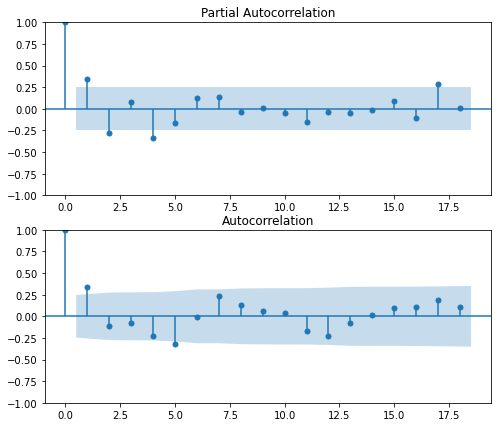

In [10]:
# plotting ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure(figsize=(8,7))
ax1 = fig.add_subplot(2,1,1)
fig = plot_pacf(dataset, ax=ax1)
ax2 = fig.add_subplot(2,1,2)
fig = plot_acf(dataset, ax=ax2)
plt.show()

From PACF graph we can determine <code>p</code> is equal 0. The theoretical PACF tapers toward 0 in some manner and partial autocorrelations are equal to 0 beyond that point. The number of non zero partial autocorrelations gives the order of the AR term. Put another way, only the vertical spikes that exceed the horizontal lines are considered significant. We can observe this behaviour on lag 0.

From ACF graph we can determine <code>q</code> order. The autocorrelations are significant for a large number of lags. Perhaps the autocorrelations at lags 2 and above are merely due to the propagation of the autocorrelation at lag 0, which is confirmed by the PACF plot. We will accept <code>q</code> as 0 or 1.

### 7. Auto ARIMA Function to Find Best Order for Model

Auto ARIMA is another function which can help us find the best fit and determine our three parameters in an automatic way. It uses a stepwise approach to search multiple combinations of <code>(p, d, q)</code> terms and chooses the best model that has the least AIC. For this task we will again use <code>pmdarima</code> module. We will just demonstrate it and not implement its results for final model.

In [11]:
# auto ARIMA function
from pmdarima import auto_arima
stepwise_fit = auto_arima(dataset['Rate'], trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=374.952, Time=0.78 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=381.240, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=375.260, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=369.948, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=454.921, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=371.543, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=371.433, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=413.573, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 1.846 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   63
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -181.974
Date:                Wed, 19 Jun 2024   AIC                            369.948
Time:                        16:20:37   BIC                            376.377
Sample:                    01-01-1960   HQIC                           372.476
                         - 01-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      7.3499      0.884      8.313      0.000       5.617       9.083
ma.L1          0.5332      0.075      7.090      0.000       0.386       0.681
sigma2        18.7982      2.463      7.632      0.000      13.971      23.626
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                19.00
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               0.09   Skew:                             0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 8. Developing the ARIMA Model

Now, that we determined and know the values of our order, we can finally implement it to ARIMA model.

In [14]:
# p=0, d=0, q=0/1
from statsmodels.tsa.arima.model import ARIMA

# fitting the model
model = ARIMA(dataset['Rate'], order=(0,0,1))
model_fit = model.fit()
model_fit.summary()

C:\Users\itsgo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\itsgo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\itsgo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Rate   No. Observations:                   63
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -181.974
Date:                Wed, 19 Jun 2024   AIC                            369.948
Time:                        16:22:49   BIC                            376.377
Sample:                    01-01-1960   HQIC                           372.476
                         - 01-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.3499      0.884      8.313      0.000       5.617       9.083
ma.L1          0.5332      0.075      7.090      0.000       0.386       0.681
sigma2        18.7981      2.463      7.632      0.000      13.971      23.626
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                19.00
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               0.09   Skew:                             0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
# predict values
pred = model_fit.predict(start=0, end=len(dataset) - 1, typ='levels', dynamic=False)

In [16]:
# display last rows
pred.tail()

2018-01-01    5.637781
2019-01-01    6.443908
2020-01-01    5.902428
2021-01-01    7.734337
2022-01-01    5.961870
Freq: AS-JAN, Name: predicted_mean, dtype: float64

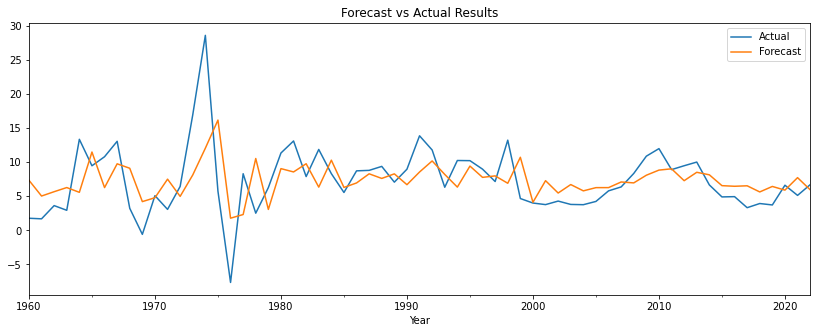

In [17]:
# plot results
dataset['Rate'].plot(legend=True, label='Actual', figsize=(14,5))
pred.plot(legend=True, label='Forecast')
plt.title('Forecast vs Actual Results')
plt.show()

### 9. Accuracy Metrics and Measure Performance of Fitted Model

We will plot diagnostics and calculate some accuracy metrics to judge the performance of our model.

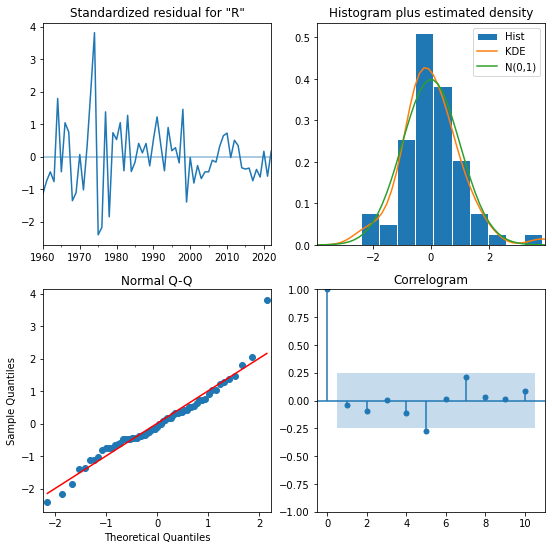

In [18]:
# diagnostic plots for standardized residuals of one endogenous variable
model_fit.plot_diagnostics(figsize=(9,9))
plt.show()

In [20]:
# root mean squared error
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(pred, dataset['Rate'], squared=False)
rmse

4.349823931774968

In [ ]:
# mean absolute error
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(pred, dataset['Rate'])
mae

In [21]:
# mean absolute percentage error
mape = np.mean(np.abs(dataset['Rate'] - pred) / dataset['Rate']) * 100
mape

37.23789989851029

In [22]:
# correlation
corr = np.corrcoef(pred, dataset['Rate'])[0,1]
corr

0.4368894409011503

### 10. Extrapolating Future Inflation Data

Now, the final part. We will forecast future inflation rates for the coming months and plot results.

In [23]:
# predict values
forecast = model_fit.predict(start=0, end=len(dataset) + 4, typ='levels', dynamic=False)

In [24]:
# display forecasted values
forecast.tail(5)

2023-01-01    7.742952
2024-01-01    7.349864
2025-01-01    7.349864
2026-01-01    7.349864
2027-01-01    7.349864
Freq: AS-JAN, Name: predicted_mean, dtype: float64

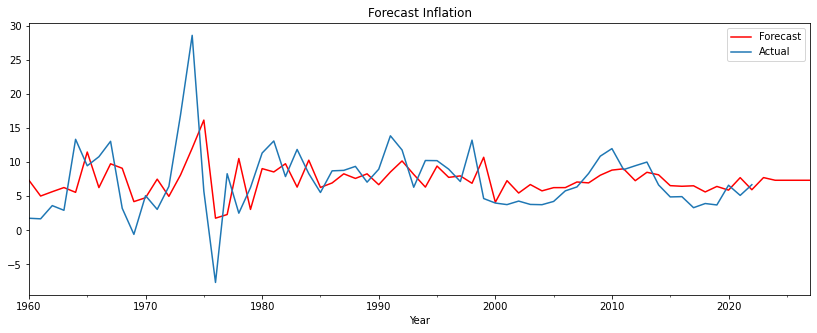

In [25]:
# final plot
forecast.plot(legend=True, label='Forecast', figsize=(14,5), color='red')
dataset['Rate'].plot(legend=True, label='Actual')
plt.title('Forecast Inflation')
plt.show()

### Conclusions

We forecasted inflation rates by developing a machine learning algorithm.

Using ARIMA model, we can forecast and analyze a time series using the series past values. We need to keep in mind ARIMA is indented for non seasonal time series. An effective and accurate ARIMA model crucially depends on its orders <code>(p, d, q)</code>. Each term requires its manual identifying. Examining ACF and PACF plots to determine order values is sometimes tricky. We also demonstrated an automatic function, with a stepwise approach to find the best fit.

Time series predicting is really useful for future decisions. It is an important part of data analysis. ARIMA model is easy to understand, matches most time series, and accurately forecasts future values. Although, it requires lots of prior knowledge to use it successfully.

Name: Gopal Vashishtha
References: https://github.com/msikorski93/Forecasting-Inflation-Rates-of-Poland/blob/main/inflation_forecast_notebook.ipynb